In [4]:
# Загружаем датасет рукописных английских букв emnist
# Каждая буква представлена в формате картинки 28х28 пикселей
import kagglehub

path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\fdsaf\.cache\kagglehub\datasets\crawford\emnist\versions\3


In [5]:
# Необходимо взять emnist-letters-test.csv и emnist-letters-train.csv
# Каждая строка в таблице - отдельная картинка
# 785 (28 x 28) столбцов, каждый столбец = величина пикселя 
# Первый столбец — это метка класса (какая это буква). Подробнее в mappings.txt
import pandas as pd # для обработки данных
testing_letter = pd.read_csv(path + '/emnist-letters-test.csv')
training_letter = pd.read_csv(path + '/emnist-letters-train.csv')

print(training_letter.shape) # 88799 = количество элементов для обучения
print(testing_letter.shape) # 14799 = кол-во элементов для тестирования

(88799, 785)
(14799, 785)


(88799,)
(88799, 784)


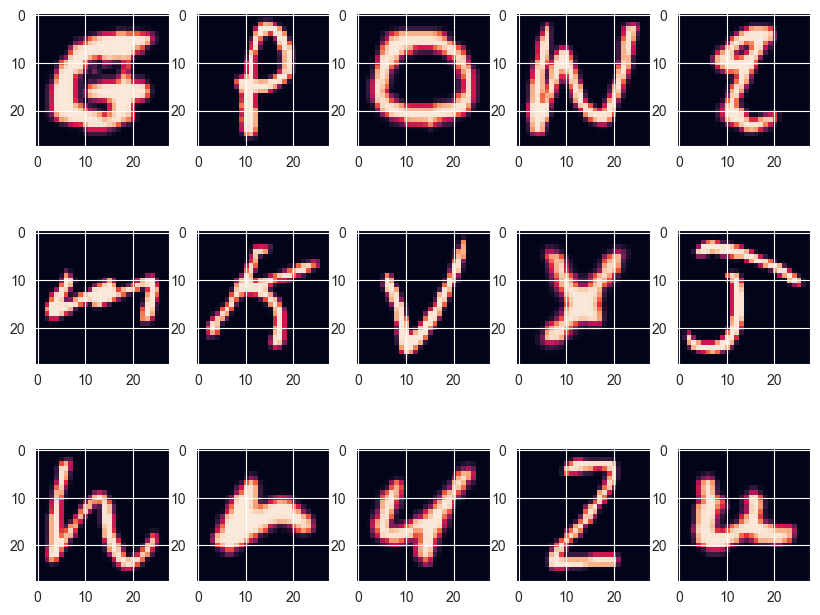

In [6]:
import numpy as np # для линейной алгебры
# training_letter
y1 = np.array(training_letter.iloc[:,0].values) # Берём первый столбец всех строк (метка класса)
x1 = np.array(training_letter.iloc[:,1:].values) # Все строки, все столбцы кроме первого столбца
# testing_letter
y2 = np.array(testing_letter.iloc[:,0].values)
x2 = np.array(testing_letter.iloc[:,1:].values)
print(y1.shape) # метки для обучающей выборки
print(x1.shape) # признаки обучающей выборки


# Проверка картинок
import matplotlib.pyplot as plt # для создания графиков
fig,axes = plt.subplots(3,5,figsize=(10,8)) # создаёт сетку 3х5 из графиков, каждая клетка размером 10х8
for i,ax in enumerate(axes.flat): # индекс, объект оси
    ax.imshow(x1[i].reshape([28,28]).T) # отображает изображение, нужно транспонировать

In [7]:
# Перед тем, как подавать в данные в модель, мы нормализуем и изменим предоставленные нам данные. Это уменьшит сложность моделей и сделает модель эффективно работать, так как для обработки будут менее сложные числа.

# Приводим данные к диапазону [0,1]
train_images = x1 / 255.0
test_images = x2 / 255.0

train_images_number = train_images.shape[0] # кол-во изображений в обучающей выборке
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)
# кол-во изображений, высота, ширина, 1 = кол-во каналов (1 т.к. чёрно белое)

test_images_number = test_images.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test_images = test_images.reshape(test_images_number, test_images_height, test_images_width, 1)

In [8]:
import tensorflow as tf

# Количество классов (26 букв английского алфавита + спец символы)
number_of_classes = 37

# Преобразует метки классов в one-hot encoding.
# Например Если y1[i] = 2, то one-hot encoding будет [0, 0, 1, 0, ..., 0] 
# (длина вектора равна number_of_classes).
y1 = tf.keras.utils.to_categorical(y1, number_of_classes)
y2 = tf.keras.utils.to_categorical(y2, number_of_classes)

In [9]:
import torch
import itertools

def binarize(images):
    return np.where(images >= 0.5, 1, -1)  # Хопфилд работает с {-1, 1}

class HopfieldNetwork:
    def __init__(self, rule="hebbian"):
        self.weights = None # Матрица весов W, будет [N x N]
        self.num_units = None # Кол-во нейронов = длина входного вектора (например, 784)
        self.rule = rule

    def train(self, patterns):
        # внутри patterns находится несколько картинок, каждая = вектор размерности 784
        # Размер массива patterns: (количество_картинок, 784)
        self.num_units = patterns.shape[1] # Длина одного вектора (обычно 784 = 28x28)
        self.weights = np.zeros((self.num_units, self.num_units))  # Инициализируем матрицу весов
        if self.rule == "hebbian":
            # Правило Хебба
            for p in patterns:
                self.weights += np.outer(p, p) # внешнее произведение: создаёт матрицу, где каждый вес w_ij = p_i * p_j
            np.fill_diagonal(self.weights, 0) # Обнуляем диагональ — нейрон не влияет сам на себя
            self.weights /= patterns.shape[0]  # Нормализуем веса по числу паттернов
        elif self.rule == "storkey":
            #print('storkey')
            for pattern in patterns:
                h = np.dot(self.weights, pattern)
                hebbian = np.outer(pattern, pattern)
                self_interaction = (np.outer(h, pattern) + np.outer(pattern, h)) / self.num_units
                self.weights += hebbian - self_interaction
            self.weights /= len(patterns)
            np.fill_diagonal(self.weights, 0)
    def recall(self, pattern, steps=5):
        # pattern: это вектор изображения, который мы хотим "очистить"
        for _ in range(steps):
            # Мы перемножаем вход pattern с весами: pattern @ weights
            #  Применяем sign → получаем вектор с элементами -1, 0, 1 (если сумма > 0 => 1, < 0 => -1)
            # Где 0, заменяем на 1 (просто техническая деталь)
            pattern = np.sign(np.dot(pattern, self.weights))  # Вычисляем новый вектор
            pattern[pattern == 0] = 1 
            # итеративная корректировка: сеть постепенно "приближается" к одному из запомненных образов.
        return pattern

class HopfieldClassifier:
    def __init__(self, rule="hebbian"):
        self.nets = {} # Словарь: ключ — метка класса, значение — отдельная сеть Хопфилда
        # будет отдельная сеть HopfieldNetwork для каждой буквы
        self.rule = rule

    def train(self, X, y):
        for label in np.unique(y): # Перебираем все уникальные метки классов
            idx = np.where(y == label)[0] # Получаем индексы всех изображений, относящихся к текущей букве label
            patterns = binarize(X[idx]) # Берём картинки только этой буквы и бинаризуем (-1 и 1)
            net = HopfieldNetwork(rule=self.rule)
            net.train(patterns) # Создаём отдельную сеть Хопфилда и обучаем её только на этой букве
            self.nets[label] = net # Сохраняем эту сеть в словарь — теперь у нас есть "одна сеть на букву"

    def predict(self, image):
        pattern = binarize(image.reshape(1, -1))[0] # Превращаем картинку в вектор + бинаризуем (-1, 1)
        similarities = {}
        for label, net in self.nets.items(): # Проход по всему словарю
            recalled = net.recall(pattern.copy()) # # Восстановить образ
            sim = np.dot(recalled, pattern)  # считает скалярное произведение между исходным (шумным) и восстановленным образом
            similarities[label] = sim # Чем выше значение → тем более похожи образы
        return max(similarities, key=similarities.get) # Выбираем ту букву (label), которая дала максимальную похожесть



In [10]:
# Функция из библиотеки scikit-learn, которая разделяет данные на обучающую и тестовую выборки.
from sklearn.model_selection import train_test_split

# Делим данные на две части: обучающая выборка (80% данных), валидационная выборка (20% данных). 
# Фиксируем случайное разбиение для воспроизводимости результатов (random_state = 42)
train_x,test_x,train_y,test_y = train_test_split(train_images,y1,test_size=0.2,random_state = 42)

# убрать канал (сейчас картинки 28×28×1 → нужно 28×28 = 784)
train_x_flat = train_x.reshape(train_x.shape[0], -1)
test_x_flat = test_x.reshape(test_x.shape[0], -1)

# Из one-hot → обратно в метку класса
train_y_labels = np.argmax(train_y, axis=1)
test_y_labels = np.argmax(test_y, axis=1)


In [11]:
clf_hebbian = HopfieldClassifier(rule="hebbian")
clf_hebbian.train(train_x_flat, train_y_labels)

In [13]:
clf_storkey = HopfieldClassifier(rule="storkey")
clf_storkey.train(train_x_flat, train_y_labels)

In [14]:
clfs = [clf_hebbian, clf_storkey]
for clf in clfs:
    predicted = np.array([clf.predict(img) for img in test_x_flat])
    true = test_y_labels
    
    accuracy = np.mean(predicted == true) # predicted == true создаёт массив True/False
    # np.mean(...) превращает True в 1, False в 0 и считает среднее значение
    print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 41.68%
Accuracy: 41.68%
Accuracy: 33.34%


Hebbian accuracy: 41.68%


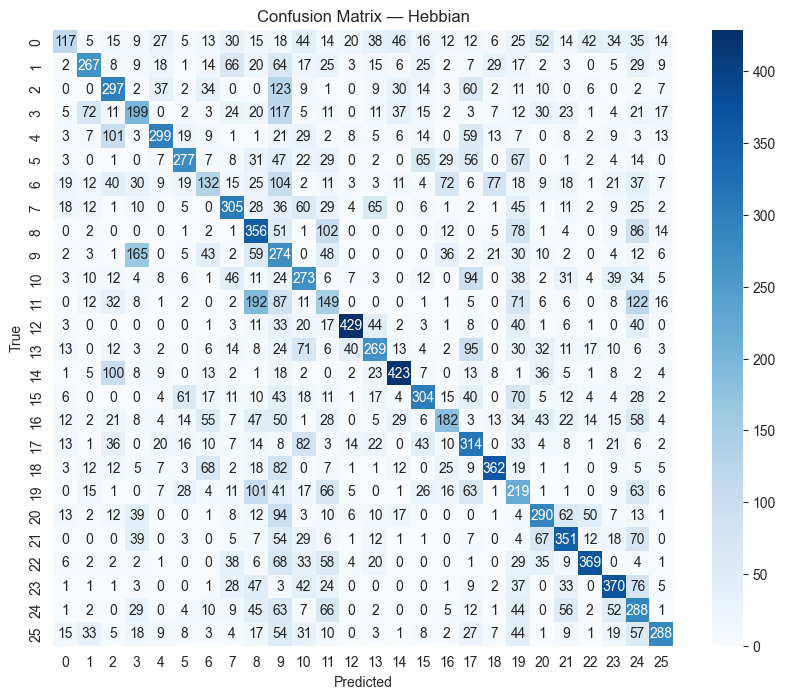

Storkey accuracy: 41.68%


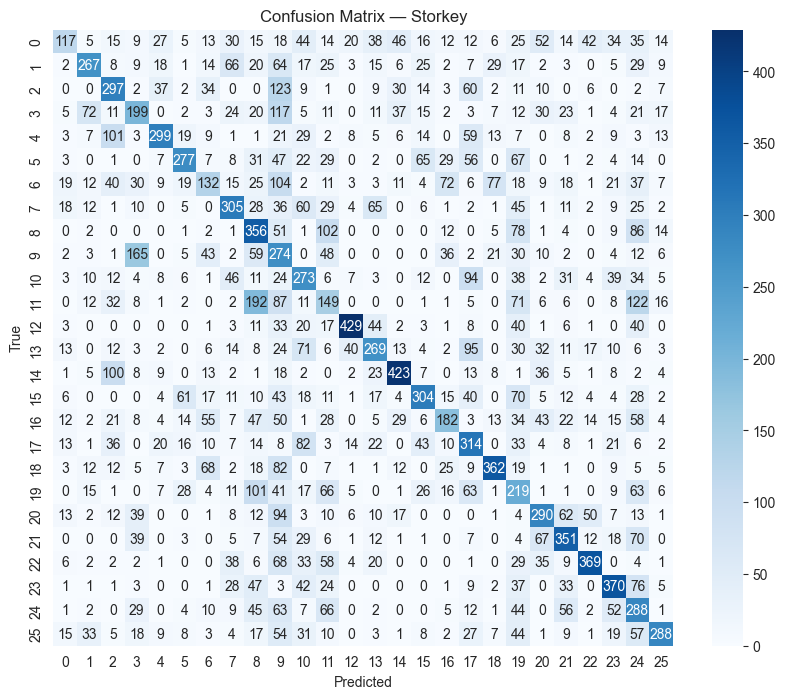

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Матрица ошибок
names = ["Hebbian", "Storkey"]

for clf, name in zip(clfs, names):
    predicted = np.array([clf.predict(img) for img in test_x_flat])
    true = test_y_labels

    accuracy = np.mean(predicted == true)
    print(f"{name} accuracy: {accuracy * 100:.2f}%")

    # Матрица ошибок
    cm = confusion_matrix(true, predicted)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

In [61]:
import random


def compare_recall_results(classifiers, labels, test_x_flat, test_y_labels, letter_index, noise_level=0.3):
    idxs = np.where(test_y_labels == letter_index)[0]
    if len(idxs) == 0:
        print("Нет изображений для этой буквы.")
        return

    original = test_x_flat[random.choice(idxs)]
    original_bin = binarize(original.reshape(1, -1))[0]

    # Добавим шум
    noisy = original_bin.copy()
    flip_indices = np.random.choice(len(noisy), size=int(noise_level * len(noisy)), replace=False)
    noisy[flip_indices] *= -1

    # Recall для всех моделей
    recalled_images = []
    for clf in classifiers:
        recalled = clf.nets[letter_index].recall(noisy.copy())
        recalled_images.append(recalled)

    def show(img, title):
        img_2d = img.reshape(28, 28)
        img_rotated = np.rot90(img_2d, k=-1)  # Поворот на 90° по часовой стрелке
        plt.imshow(img_rotated, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.figure(figsize=(12, 4))

    plt.subplot(1, len(classifiers) + 2, 1)
    show(original_bin, "Original")

    plt.subplot(1, len(classifiers) + 2, 2)
    show(noisy, f"Noisy\n{int(noise_level*100)}%")

    for i, (img, label) in enumerate(zip(recalled_images, labels)):
        plt.subplot(1, len(classifiers) + 2, i + 3)
        show(img, f"Recalled\n{label}")

    plt.suptitle(f"Letter: {chr(ord('A') + letter_index - 1)}")
    plt.tight_layout()
    plt.show()

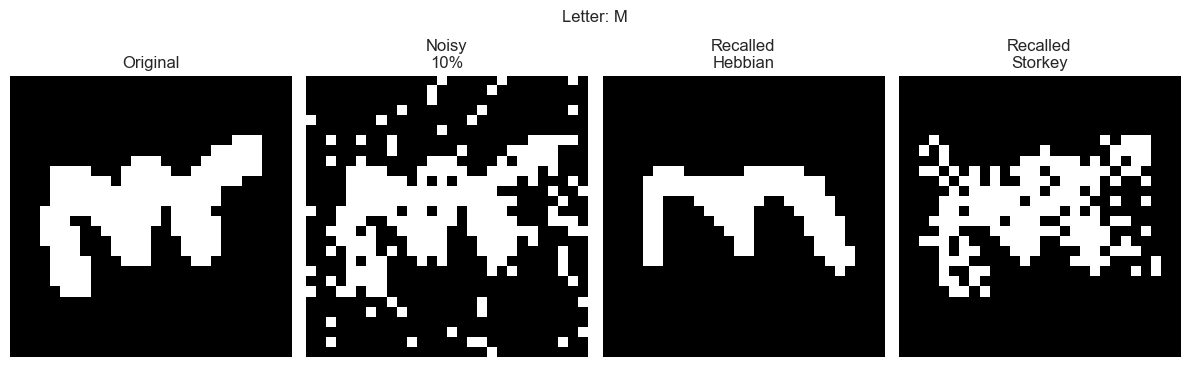

In [94]:
compare_recall_results(
    classifiers=[clf_hebbian, clf_storkey],
    labels=["Hebbian", "Storkey"],
    test_x_flat=test_x_flat,
    test_y_labels=test_y_labels,
    letter_index=13,
    noise_level=0.1
)